In [2]:
from glob import glob
import sys, time, os, asyncio
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from astropy.time import Time, TimeDelta
from scipy.interpolate import UnivariateSpline

from lsst_efd_client import EfdClient, resample, merge_packed_time_series, rendezvous_dataframes
from lsst.ts.idl.enums import MTM1M3

from scipy.signal import find_peaks
from scipy.interpolate import interp1d

In [13]:
flist=glob("/home/p/pferguso/u/repos/sitcom/notebooks_vandv/scripts/data/oscillation*.csv")
event_types=pd.read_csv("/home/p/pferguso/u/repos/sitcom/notebooks_vandv/scripts/data/o_shapes.csv")

In [14]:
flist

['/home/p/pferguso/u/repos/sitcom/notebooks_vandv/scripts/data/oscillation_events_2023-05-29T14:01:00.000_to_2023-05-30T14:01:00.000.csv',
 '/home/p/pferguso/u/repos/sitcom/notebooks_vandv/scripts/data/oscillation_events_2023-05-31T14:01:00.000_to_2023-06-01T14:01:00.000.csv',
 '/home/p/pferguso/u/repos/sitcom/notebooks_vandv/scripts/data/oscillation_events_2023-06-19T14:01:00.000_to_2023-06-20T14:01:00.000.csv',
 '/home/p/pferguso/u/repos/sitcom/notebooks_vandv/scripts/data/oscillation_events_2023-05-26T14:01:00.000_to_2023-05-27T14:01:00.000.csv',
 '/home/p/pferguso/u/repos/sitcom/notebooks_vandv/scripts/data/oscillation_events_2023-05-30T14:01:00.000_to_2023-05-31T14:01:00.000.csv',
 '/home/p/pferguso/u/repos/sitcom/notebooks_vandv/scripts/data/oscillation_events_2023-06-01T14:01:00.000_to_2023-06-02T14:01:00.000.csv',
 '/home/p/pferguso/u/repos/sitcom/notebooks_vandv/scripts/data/oscillation_events_2023-06-15T14:01:00.000_to_2023-06-16T14:01:00.000.csv']

In [15]:
frame_list=[]
for file in flist:
    frame_list.append(pd.read_csv(file))
overall_frame=pd.concat(frame_list)

In [28]:
overall_frame["iso_time"]=Time(overall_frame["times"], format="unix").iso

In [31]:
pd.concat([overall_frame.iloc[:,1:].reset_index(drop=True), event_types.reset_index(drop=True)], axis=1).to_csv("./oscillation_frame_labeled.csv", index=False)

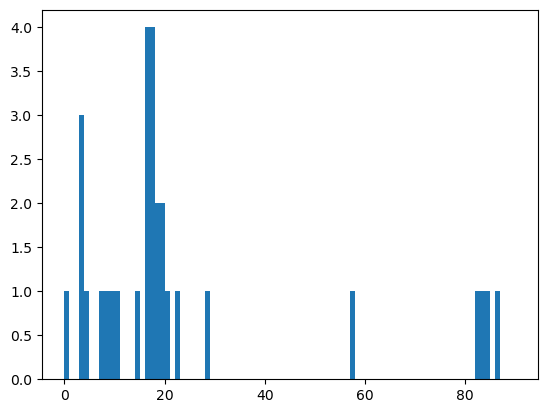

In [95]:
_=plt.hist(overall_frame["elevation_position"][overall_frame["elevation_velocity"] < 0], range=[0,90], bins=90)

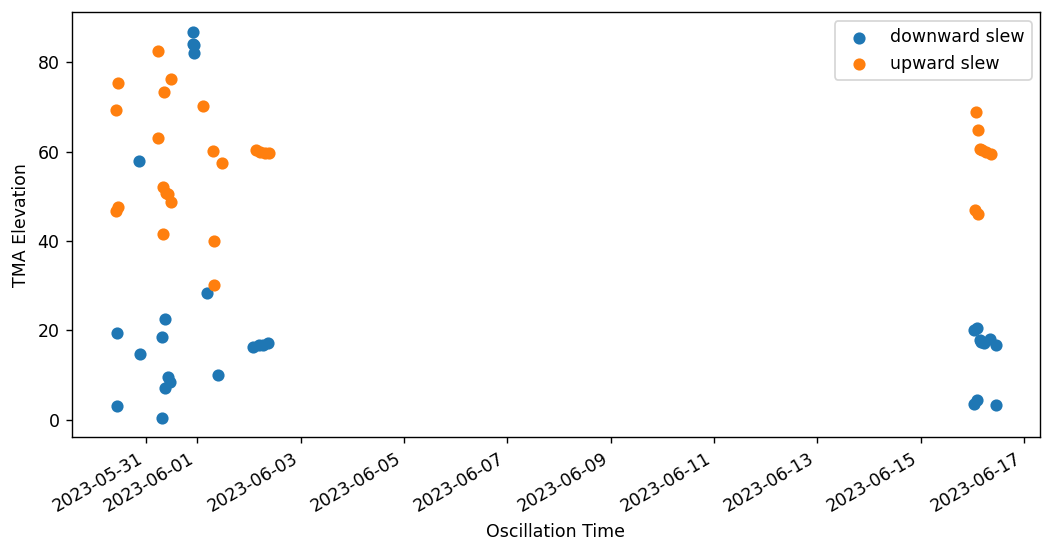

In [96]:
x=overall_frame["times"][overall_frame["slew_state"] == True]
y=overall_frame["elevation_position"]
z=overall_frame["elevation_velocity"]
fig, ax=plt.subplots(1, dpi=125, figsize=(10,5))
ax.scatter(Time(x[z <=0], format="unix").datetime,y[z <=0], label="downward slew")
ax.scatter(Time(x[z > 0], format="unix").datetime,y[z > 0], label="upward slew")
plt.legend()
ax.set_xlabel("Oscillation Time")
ax.set_ylabel("TMA Elevation")
fig.autofmt_xdate()

In [38]:
overall_frame.iloc[:,1:].to_csv("../../../../scripts/data/combined_events.csv",index=False)

In [85]:
sel=(overall_frame["times"] < (overall_frame["times"].min() + 24*60*60*5))
x=overall_frame["times"][sel]
y=overall_frame["elevation_position"][sel]
z=overall_frame["elevation_velocity"][sel]


In [ ]:
fig, ax=plt.subplots(1, dpi=125, figsize=(10,5))
sel = (
_=ax.scatter(Time(x[z <=0], format="unix").datetime,y[z <=0], label="downward slew", c=(event_types["group"].values[z <=0]), marker="D", vmin=0, vmax=5)
_=ax.scatter(Time(x[z >=0], format="unix").datetime,y[z >=0], label="downward slew", c=(event_types["group"].values[z >=0]), marker="X", vmin=0, vmax=5)
#ax.scatter(Time(x[z > 0], format="unix").datetime,y[z > 0], label="upward slew")
plt.colorbar(_)
ax.set_xlabel("Oscillation Time")
ax.set_ylabel("TMA Elevation")

fig.autofmt_xdate()



In [103]:
group_dict={1:"upward shift",2:"downward shift",3:"p cygni",4:"scoop"}
group_color=["tab:blue","tab:orange", "tab:green", "tab:red"]

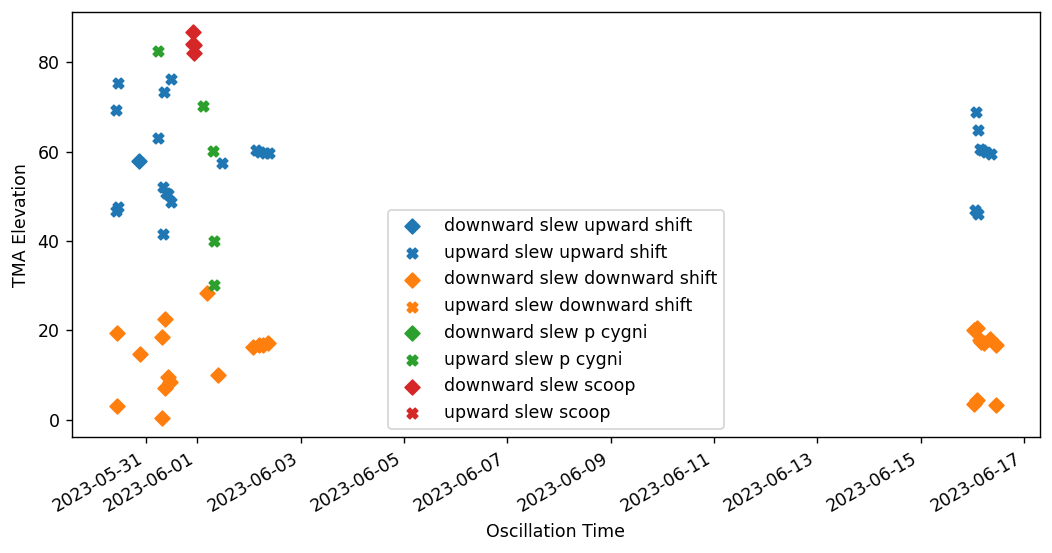

In [110]:
fig, ax=plt.subplots(1, dpi=125, figsize=(10,5))
selz=(z <= 0)
for j in group_dict.keys():
    sel1 = selz & (event_types["group"].values == j)
    sel2 = ~selz & (event_types["group"].values == j)
    _=ax.scatter(Time(x[sel1], format="unix").datetime,
                 y[sel1], 
                 label=f"downward slew {group_dict[j]}", 
                 c=group_color[j-1], marker="D")
    _=ax.scatter(Time(x[sel2], format="unix").datetime,
                 y[sel2], 
                 label=f"upward slew {group_dict[j]}", 
                 c=group_color[j-1], marker="X")
#    _=ax.scatter(Time(x[z >=0], format="unix").datetime,y[z >=0], label="downward slew", c=(event_types["group"].values[z >=0]), marker="X", vmin=0, vmax=5)
#ax.scatter(Time(x[z > 0], format="unix").datetime,y[z > 0], label="upward slew")
ax.legend()
ax.set_xlabel("Oscillation Time")
ax.set_ylabel("TMA Elevation")

fig.autofmt_xdate()



(array([ 8.,  0.,  0.,  0., 25.,  0., 12.,  0.,  7.,  8.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

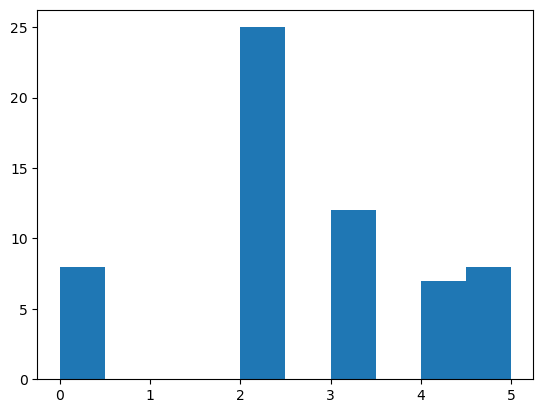

In [88]:
plt.hist(overall_frame["actuators"])